In [9]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
!python3 -m spacy download en_core_web_sm

In [11]:
pd.set_option('max_colwidth', 400)

### Набор данных
[
SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being **ham** (legitimate) or **spam**.

In [12]:
data = pd.read_csv('spam_data.csv', encoding='iso-8859-1')[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [13]:
data['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [14]:
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

### Очистка

Стоп-слова для англиского языка в spaCy

In [15]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
print(f'Spacy english stopwords size: {len(stopwords)}', end='\n\n')
' '.join(stopwords)

Spacy english stopwords size: 326



"after none cannot should hereby us that where be seeming four not since each ‘ve among most themselves below indeed beyond down been sometimes namely through than besides n’t are moreover him although a no 'll two empty until you ’m forty up behind herself 'm twenty also somehow whenever please except amongst sixty who some and else several bottom become is both show which do if someone only has what then anyway perhaps everywhere seems does it somewhere sometime may ‘d well ca the afterwards nothing next done i at take further every too anyone mostly eleven whereas third of often everything its least nor rather either amount those hereafter am though becoming using many an even becomes never therefore whole 're ten myself onto without our put this how seemed really such to give whoever but six via almost will eight always say former much all ’ve within anywhere full hence regarding as unless noone just throughout against ‘re nine alone might over ever made enough into beside whatever

Атрибуты [Token](https://spacy.io/api/token#attributes)

In [16]:
%%time

data['cleaned_text'] = data['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if 
        not token.is_stop 
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.sample(5)

CPU times: user 52.7 s, sys: 225 ms, total: 52.9 s
Wall time: 1min


,label,text,cleaned_text
3395,1,URGENT! Your Mobile number has been awarded with a å£2000 Bonus Caller Prize. Call 09058095201 from land line. Valid 12hrs only,urgent mobile number award å£2000 bonus caller prize land line valid 12hrs
246,0,I asked you to call him now ok,ask ok
5241,0,Its a part of checking IQ,check iq
1897,0,"Aight, sounds good. When do you want me to come down?",aight sound good want come
493,0,What class of &lt;#&gt; reunion?,class lt;#&gt reunion


In [17]:
data['cleaned_text'].iloc[3]

'u dun early hor u c'

### Bag of words

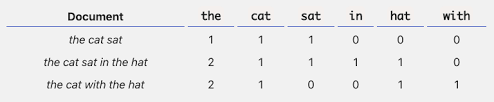

#### CountVectorizer

- приводит к нижнему регистру
- проводит токенизацию - `r"(?u)\b\w\w+\b"` (токены из 2 или более буквенно-цифровых символов, пунктуация полностью игнорируется и всегда рассматривается как разделитель токенов)
  - `(?u)` - флаг Unicode
  - `\b` - граница слова
  - `\w` - символы, которые могут входить в состав слов, включая числа и подчёркивание
  - `\+` - 1 и более повторений предшествующего выражения
- фильтрует стоп-слова

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

##### Стоп-слова

In [19]:
print(f'Sklearn english stopwords size: {len(ENGLISH_STOP_WORDS)}', end='\n\n')
' '.join(ENGLISH_STOP_WORDS)

Sklearn english stopwords size: 318



'after none cannot should hereby us that found where be seeming four con not since each thin among most themselves below indeed beyond down been sometimes namely through than besides are moreover him fill although a eg no two empty until you thick forty interest de up behind herself twenty also somehow hasnt whenever please except amongst sixty who some mill sincere and else several bottom become inc is both show which do if someone only has what then anyway cant perhaps everywhere seems it somewhere sometime may well the afterwards bill etc nothing next done i at take further every too anyone mostly eleven whereas third of often find everything its least nor un rather either amount those hereafter am though becoming many an even becomes never therefore whole ten myself onto without our put this how seemed such to give whoever but six via almost will eight always former much all within anywhere full hence as noone throughout against nine alone might over fire detail ever made enough in

This list of English stop words is taken from the "Glasgow Information Retrieval Group". The original list can be found at
http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words

##### Train/test split & fit

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], random_state=2023)

In [21]:
vectorizer = CountVectorizer(max_df=0.7, min_df=0.003) # max_df фильтрует corpus-specific stop words
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

##### Разреженное представление результата

Поскольку в большинстве документов обычно используется очень небольшое подмножество слов, используемых в корпусе, результирующая матрица будет иметь много нулевых значений признаков (обычно более 99% из них).

Чтобы оптимально хранить такую матрицу в памяти, а также ускорить алгебраические операции с матрицей/вектором, обычно используют разреженное представление, такое как реализации, доступные в пакете scipy.sparse.


[Sparse matrices (scipy.sparse)](https://docs.scipy.org/doc/scipy/reference/sparse.html)

**CSR** - Compressed Sparse Row

**COO** - COOrdinate format

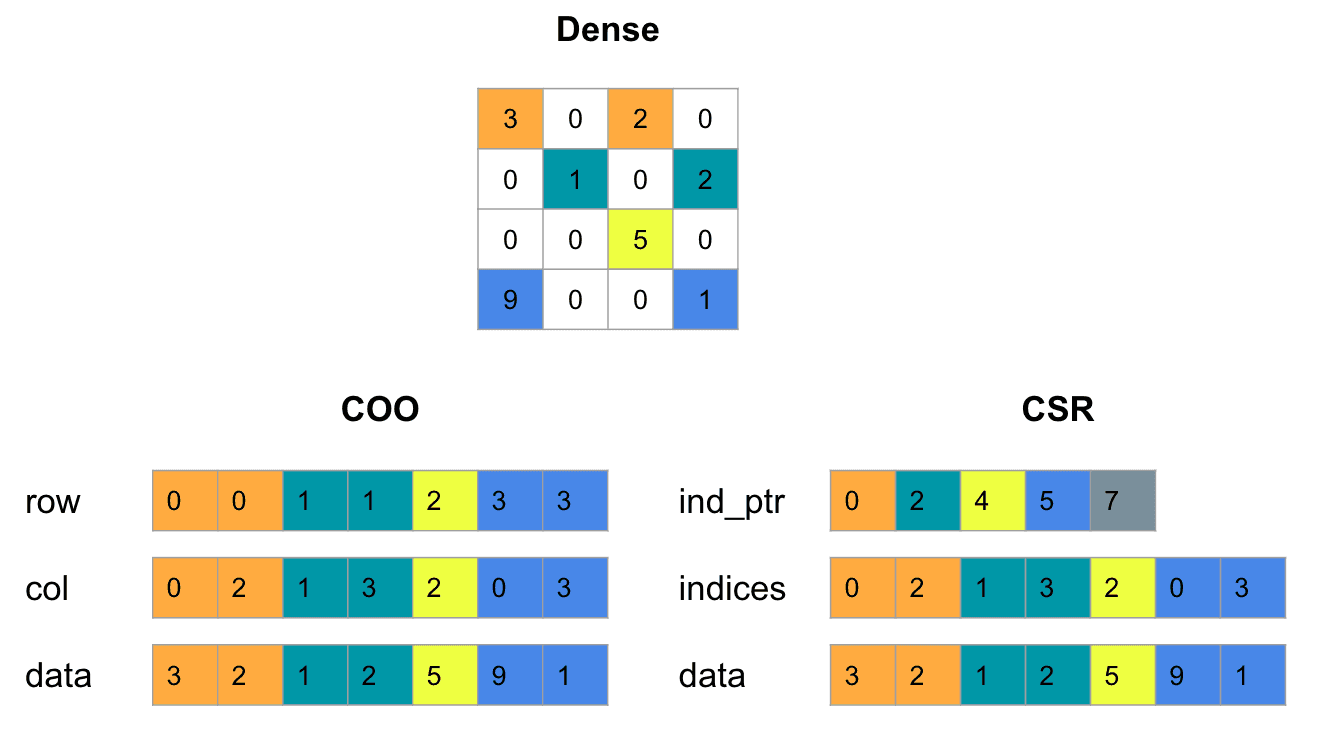

In [22]:
X_train_vectorized

<4179x452 sparse matrix of type '<class 'numpy.int64'>'
	with 18038 stored elements in Compressed Sparse Row format>

In [23]:
vectorizer.get_feature_names_out()

array(['000', '10', '100', '1000', '10p', '150p', '150ppm', '2000', '50',
       '500', '5000', 'able', 'abt', 'account', 'actually', 'add',
       'address', 'aft', 'afternoon', 'age', 'ah', 'aight', 'alright',
       'amp', 'answer', 'anytime', 'apply', 'ard', 'ask', 'attempt',
       'await', 'award', 'away', 'babe', 'baby', 'bad', 'beautiful',
       'bed', 'believe', 'big', 'birthday', 'bit', 'bonus', 'book',
       'bored', 'box', 'boy', 'boytoy', 'break', 'bring', 'brother', 'bt',
       'bus', 'busy', 'buy', 'call', 'camera', 'car', 'card', 'care',
       'carlos', 'cash', 'cause', 'chance', 'change', 'charge', 'chat',
       'check', 'chikku', 'choose', 'claim', 'class', 'close', 'co',
       'code', 'collect', 'collection', 'colour', 'com', 'come',
       'confirm', 'congrat', 'contact', 'cool', 'cos', 'cost', 'coz',
       'crazy', 'credit', 'cs', 'cum', 'customer', 'da', 'dad', 'darlin',
       'dat', 'date', 'day', 'de', 'dear', 'decide', 'decimal',
       'delivery', 'den

In [24]:
pd.DataFrame(X_train_vectorized.toarray(), columns=vectorizer.get_feature_names_out()).head()

,000,10,100,1000,10p,150p,150ppm,2000,50,500,...,xxx,ya,yeah,year,yes,yesterday,yo,you,yup,ìï
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Бейзлайн

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

Константное предсказание

In [26]:
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train_vectorized, y_train)
preds = dummy_clf.predict(X_test_vectorized)
print(classification_report(y_test, preds, zero_division=0))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       0.00      0.00      0.00       186

    accuracy                           0.87      1393
   macro avg       0.43      0.50      0.46      1393
weighted avg       0.75      0.87      0.80      1393



Логистическая регрессия

In [27]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.97      0.82      0.89       186

    accuracy                           0.97      1393
   macro avg       0.97      0.91      0.94      1393
weighted avg       0.97      0.97      0.97      1393



##### Переопределение токенизатора, препроцессинга

In [28]:
def custom_tokenize(text):
  text = re.sub(r'[^a-zA-Z ]', '', text)
  return text.split()

In [29]:
custom_vectorizer = CountVectorizer(
    max_df=0.7, 
    min_df=0.003, 
    tokenizer=custom_tokenize, # аналогично можно переопределить preprocessor
) 
X_train_vectorized = custom_vectorizer.fit_transform(X_train)
X_test_vectorized = custom_vectorizer.transform(X_test)

In [30]:
X_train_vectorized

<4179x447 sparse matrix of type '<class 'numpy.int64'>'
	with 18729 stored elements in Compressed Sparse Row format>

In [31]:
pd.DataFrame(X_train_vectorized.toarray(), columns=custom_vectorizer.get_feature_names_out()).head()

,able,abt,account,actually,add,address,aft,afternoon,age,ah,...,xxx,y,ya,yeah,year,yes,yesterday,yo,yr,yup
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
logreg = LogisticRegression().fit(X_train_vectorized, y_train)
preds = logreg.predict(X_test_vectorized)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1207
           1       0.99      0.83      0.90       186

    accuracy                           0.98      1393
   macro avg       0.98      0.92      0.95      1393
weighted avg       0.98      0.98      0.98      1393



### Tf-Idf

В объемном корпусе некоторые слова будут присутствовать в большом количестве документов (текстов), а значит, они несут очень мало значимой информации о фактическом содержании документа. 

Для решения этой проблемы можно использовать Tf-Idf подход

Цель использования tf-idf состоит в том, чтобы уменьшить влияние токенов, которые очень часто встречаются в данном корпусе и, следовательно, эмпирически менее информативны, чем признаки, которые встречаются малой части корпуса



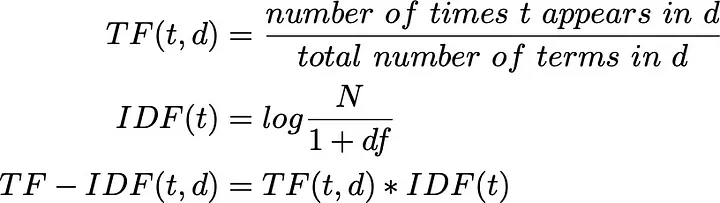

Можно заметить, что **term-frequency** изменяется в диапазоне [0, 1]

тогда как без логарифмирования **inverse document-frequency** - [1, N + 1]

#### Отличия в реализации Sklearn

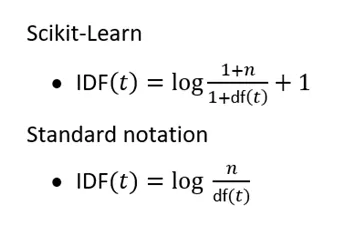

Также в Scikit-Learn результирующие векторы TF-IDF нормализуются по евклидовой норме, что облегчает расчет cosine similarity:
`The cosine similarity between two vectors is their dot product when l2 norm has been applied`

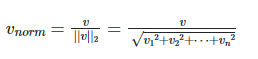

#### TfidfTransformer vs  TfidfVectorizer

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer,  TfidfVectorizer
from sklearn.pipeline import Pipeline

**TfidfTransformer** преобразует матрицу из CountVectorizer в tf-idf

In [34]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1207
           1       0.99      0.71      0.83       186

    accuracy                           0.96      1393
   macro avg       0.97      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



**TfidfVectorizer** работает end-to-end

In [35]:
pipe = Pipeline(
    steps=[
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression())
    ]
).fit(X_train, y_train)
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1207
           1       0.99      0.71      0.83       186

    accuracy                           0.96      1393
   macro avg       0.97      0.85      0.90      1393
weighted avg       0.96      0.96      0.96      1393



#### Оптимизация гиперпараметров пайплайна целиком - HalvingGridSearchCV

In [36]:
pipe = Pipeline(
    steps=[
        ('counter', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', LogisticRegression())
    ]
)

In [37]:
parameter_grid = {
    "counter__max_df": np.linspace(0.3, 0.7, 10),
    "counter__min_df": [0.0, 0.001, 0.003, 0.005],
    "counter__ngram_range": ((1, 1), (1, 2)),  # слова или биграммы
    "tfidf__norm": ("l1", "l2"),
    "clf__C": np.linspace(0.1, 1, 10),
}

In [38]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [ ]:
%%time

grid_search = HalvingGridSearchCV(
    pipe,
    param_grid=parameter_grid,
    n_jobs=-1,
    verbose=1,
    cv=2,
    scoring='accuracy',
)
grid_search.fit(X_train, y_train)

In [44]:
plt.rcParams["figure.figsize"] = (12, 8)

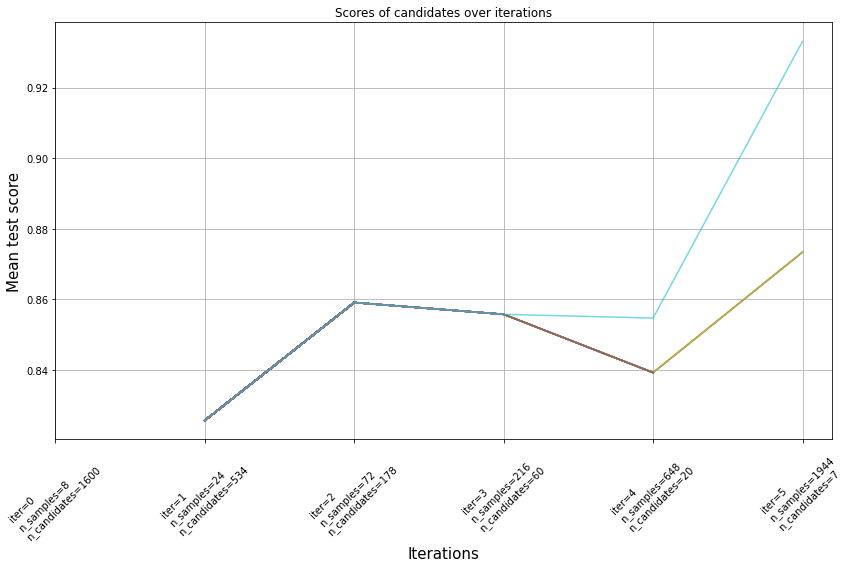

In [63]:
results = pd.DataFrame(grid_search.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", 
    columns="params_str",
     values="mean_test_score",
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={grid_search.n_resources_[i]}\nn_candidates={grid_search.n_candidates_[i]}"
    for i in range(grid_search.n_iterations_)
]

ax.set_xticks(range(grid_search.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("Mean test score", fontsize=15)
ax.set_xlabel("Iterations", fontsize=15)
plt.tight_layout()
plt.grid()
plt.show()

In [46]:
grid_search.best_score_

0.8285490038231625

In [47]:
preds = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1207
           1       0.98      0.77      0.86       186

    accuracy                           0.97      1393
   macro avg       0.97      0.88      0.92      1393
weighted avg       0.97      0.97      0.97      1393



#### Визуализация & Интерпретация 

##### Altair

[Altair](https://https://github.com/altair-viz/altair) - declarative statistical visualization library for Python

In [ ]:
!pip install altair

In [49]:
tfidf = TfidfVectorizer(tokenizer=custom_tokenize, max_df=0.7, min_df=0.003, )
transformed = tfidf.fit_transform(X_train)

In [50]:
tfidf_df = pd.DataFrame(transformed.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df = tfidf_df.stack().reset_index().rename(columns={0: 'tfidf', 'level_0': 'document', 'level_1': 'term', 'level_2': 'term'})
tfidf_df = tfidf_df.sort_values(by=['document', 'tfidf'], ascending=[True, False]).groupby(['document']).head()
tfidf_df.head()

,document,term,tfidf
286,0,place,0.884920
215,0,lot,0.465743
0,0,able,0.000000
1,0,abt,0.000000
2,0,account,0.000000


In [51]:
tfidf_df.sort_values(by='tfidf', ascending=False).head(100)

,document,term,tfidf
592428,1325,haf,1.0
1431262,3201,way,1.0
1416808,3169,ok,1.0
843140,1886,dream,1.0
1417429,3170,ya,1.0
...,...,...,...
455894,1019,v,1.0
894612,2001,hello,1.0
1504075,3364,tell,1.0
487042,1089,not,1.0


In [54]:
tfidf_df.iloc[100:200]

,document,term,tfidf
9381,20,year,0.574959
9099,20,happy,0.561479
9191,20,new,0.507319
9333,20,u,0.311111
8940,20,able,0.000000
...,...,...,...
17766,39,send,0.757161
17719,39,place,0.341547
17673,39,money,0.340259
17802,39,text,0.268312


In [55]:
import altair as alt

In [56]:
term_list = ['free', 'money']

top_tfidf_df = tfidf_df[tfidf_df['tfidf'] != 0]

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_df.iloc[300:400]).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)

heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)

circle = base.mark_circle(size=100).encode(
    color = alt.condition(
        alt.FieldOneOfPredicate(field='term', oneOf=term_list),
        alt.value('red'),
        alt.value('#FFFFFF00')        
    )
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + circle + text).properties(width = 600) #circle

alt.LayerChart(...)

##### ELI5

[eli5](https://eli5.readthedocs.io/en/latest/) - Python library which allows to visualize and debug various Machine Learning models using unified API. It has built-in support for several ML frameworks and provides a way to explain black-box models.

In [ ]:
!pip install eli5

In [59]:
import eli5

In [60]:
grid_search.best_estimator_['clf']

LogisticRegression()

In [61]:
eli5.show_weights(
    estimator=grid_search.best_estimator_['clf'], 
    feature_names= list(grid_search.best_estimator_['counter'].get_feature_names_out()),
    top=(50, 5)
)

Weight?,Feature
+4.395,txt
+3.863,claim
+3.725,mobile
+3.433,www
+3.296,150p
+3.177,win
+3.075,free
+3.052,service
+2.920,stop
+2.874,50
